In [2]:
# Verificar e instalar xgboost si no está disponible
try:
    import xgboost
    print("✅ xgboost ya está instalado.")
except ImportError:
    print("⚠️ xgboost no está instalado. Instalando...")
    import sys
    !{sys.executable} -m pip install xgboost


⚠️ xgboost no está instalado. Instalando...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00


In [25]:
import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# 1. Cargar todos los df_20xx_period CSV
data_path = "/Users/paulasanchezalvarez/Desktop/red_electrica/data" 
df_files = glob.glob(os.path.join(data_path, "df_20*_*.csv"))

df_list = []
for file in df_files:
    df_temp = pd.read_csv(file)
    df_temp['source_file'] = os.path.basename(file)

    # Extraer anio y periodo del nombre del archivo
    parts = os.path.basename(file).replace(".csv", "").split("_")
    df_temp["anio"] = int(parts[1])
    df_temp["periodo"] = parts[2]

    df_list.append(df_temp)

In [5]:
# Concatenar todos los dataframes en uno
df_features = pd.concat(df_list, ignore_index=True)
print(f"✅ Features cargadas: {df_features.shape}")

✅ Features cargadas: (736022, 5)


In [6]:
# 2. Unir CSVs de demanda real
demanda_files = glob.glob(os.path.join(data_path, "export_DemandaReal_*.csv"))
df_demanda = pd.concat([pd.read_csv(f, sep= ";") for f in demanda_files], ignore_index=True)
print(f"✅ Demanda real cargada: {df_demanda.shape}")

✅ Demanda real cargada: (98489, 6)


In [7]:
df_demanda.head(5)

,id,name,geoid,geoname,value,datetime
0,1293,Demanda real,NaN,NaN,19967.833333,2023-01-02T00:00:00+01:00
1,1293,Demanda real,NaN,NaN,18580.666667,2023-01-02T01:00:00+01:00
2,1293,Demanda real,NaN,NaN,17674.916667,2023-01-02T02:00:00+01:00
3,1293,Demanda real,NaN,NaN,17235.416667,2023-01-02T03:00:00+01:00
4,1293,Demanda real,NaN,NaN,17210.000000,2023-01-02T04:00:00+01:00


In [9]:
# 3. Procesar demanda real
df_demanda.rename(columns={"value": "demanda", "datetime": "fecha"}, inplace=True)

# Forzamos conversión y eliminamos los NaT
df_demanda["fecha"] = pd.to_datetime(df_demanda["fecha"], errors='coerce')
df_demanda = df_demanda.dropna(subset=["fecha"])

# Confirmamos que la columna ahora es datetime
if not pd.api.types.is_datetime64_any_dtype(df_demanda["fecha"]):
    raise ValueError("La columna 'fecha' no está en formato datetime")

# Extraemos anio y mes
df_demanda["anio"] = df_demanda["fecha"].dt.year
df_demanda["mes"] = df_demanda["fecha"].dt.month

def clasificar_periodo(mes):
    if mes in [1, 2, 3]:
        return "first"
    elif mes in [4, 5, 6]:
        return "second"
    elif mes in [7, 8, 9]:
        return "third"
    else:
        return "fourth"

df_demanda["periodo"] = df_demanda["mes"].apply(clasificar_periodo)

# Agregamos promedio de demanda por anio + periodo
df_demanda = df_demanda.groupby(["anio", "periodo"])["demanda"].mean().reset_index()
print(f"📊 Demanda procesada: {df_demanda.shape}")


📊 Demanda procesada: (23, 3)


In [10]:
# 4. Merge entre features y demanda
merged_df = pd.merge(df_features, df_demanda, on=["anio", "periodo"], how="inner")
print(f"🔗 Merge features + demanda: {merged_df.shape}")

🔗 Merge features + demanda: (249322, 6)


In [11]:
merged_df.tail()

,datetime_utc,Demanda real,source_file,anio,periodo,demanda
249317,2024-04-29 21:40:00+00:00,24718.0,df_2024_first_period.csv,2024,first,27161.371724
249318,2024-04-29 21:45:00+00:00,24564.0,df_2024_first_period.csv,2024,first,27161.371724
249319,2024-04-29 21:50:00+00:00,24381.0,df_2024_first_period.csv,2024,first,27161.371724
249320,2024-04-29 21:55:00+00:00,24228.0,df_2024_first_period.csv,2024,first,27161.371724
249321,2024-04-29 22:00:00+00:00,23935.0,df_2024_first_period.csv,2024,first,27161.371724


In [13]:
# 5. Guardar dataset consolidado en la carpeta data
output_path = os.path.join(data_path, "dataset_modelado.csv")
merged_df.to_csv(output_path, index=False)
print(f"✅ Dataset consolidado guardado en: {output_path}")

✅ Dataset consolidado guardado en: /Users/paulasanchezalvarez/Desktop/red_electrica/data/dataset_modelado.csv


In [19]:
#Preparar features y target
X = merged_df.drop(columns=["demanda", "anio", "periodo", "source_file"], errors="ignore")
X = X.select_dtypes(include=["number"])  # nos aseguramos de quedarnos solo con columnas numéricas
y = merged_df["demanda"]

In [20]:
#Split en entrenamiento y test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [21]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [22]:
# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [26]:
# Evaluación
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n📊 Resultados Random Forest:")
print(f"MAE: {mae_rf:.2f} | RMSE: {rmse_rf:.2f} | R²: {r2_rf:.2f}")

print("\n📊 Resultados XGBoost:")
print(f"MAE: {mae_xgb:.2f} | RMSE: {rmse_xgb:.2f} | R²: {r2_xgb:.2f}")


📊 Resultados Random Forest:
MAE: 1604.26 | RMSE: 1674.87 | R²: -0.43

📊 Resultados XGBoost:
MAE: 1599.96 | RMSE: 1648.49 | R²: -0.39


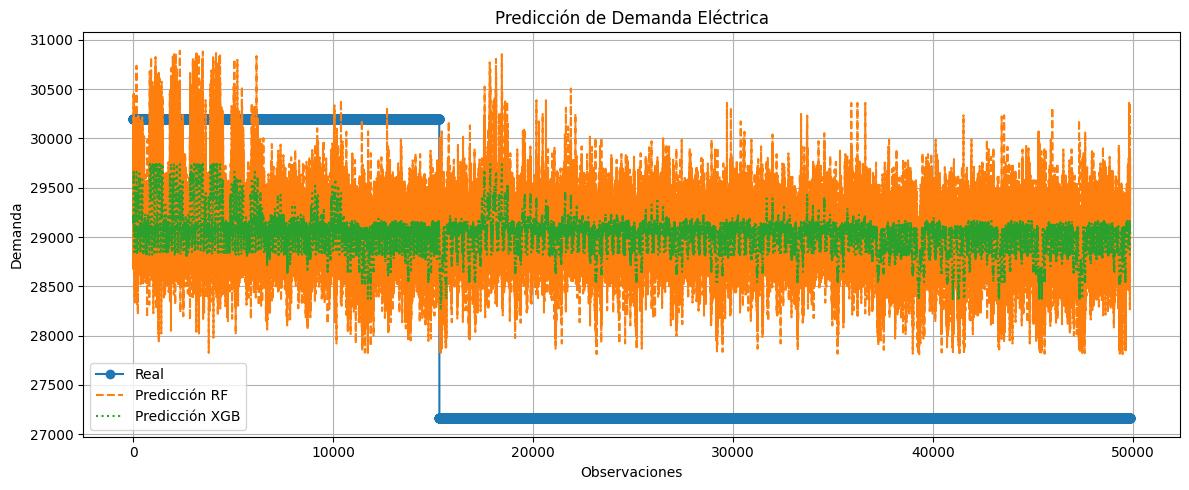

In [27]:
# Gráfico comparativo
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Real", marker='o')
plt.plot(y_pred_rf, label="Predicción RF", linestyle="--")
plt.plot(y_pred_xgb, label="Predicción XGB", linestyle=":")
plt.legend()
plt.title("Predicción de Demanda Eléctrica")
plt.xlabel("Observaciones")
plt.ylabel("Demanda")
plt.grid(True)
plt.tight_layout()
plt.show()

En tu gráfico hay mucho ruido visual, lo que sugiere que los datos son muy densos (quizás con valores por hora o más frecuente).
Aun así, parece que XGBoost (verde) está más alineado con la línea real, lo cual suele pasar porque XGBoost es muy potente en regresión.

Con las métricas que calculaste (MAE, RMSE, R²), podés comparar numéricamente cuál modelo lo hizo mejor. Generalmente:

Menor MAE y RMSE = mejor.
R² cercano a 1 = bueno.
